In [126]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Carga de datos


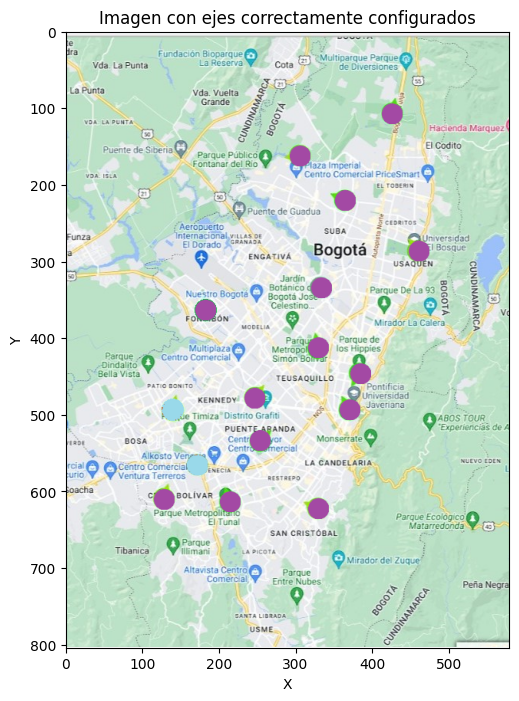

In [176]:
# image_path = '../Mapita.png'
image_path = '../../Data/Map.png'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Obtener dimensiones de la imagen
height, width, _ = image.shape

# Mostrar la imagen con los ejes correctamente configurados
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
# # Establecer los límites de los ejes
plt.xlim(0, width)
plt.ylim(height, 0) 

# # Invertir el eje Y para que el origen esté en la esquina inferior izquierda

# plt.gca().invert_yaxis()

# Títulos y etiquetas
plt.title('Imagen con ejes correctamente configurados')
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

# Lectura de la imagen

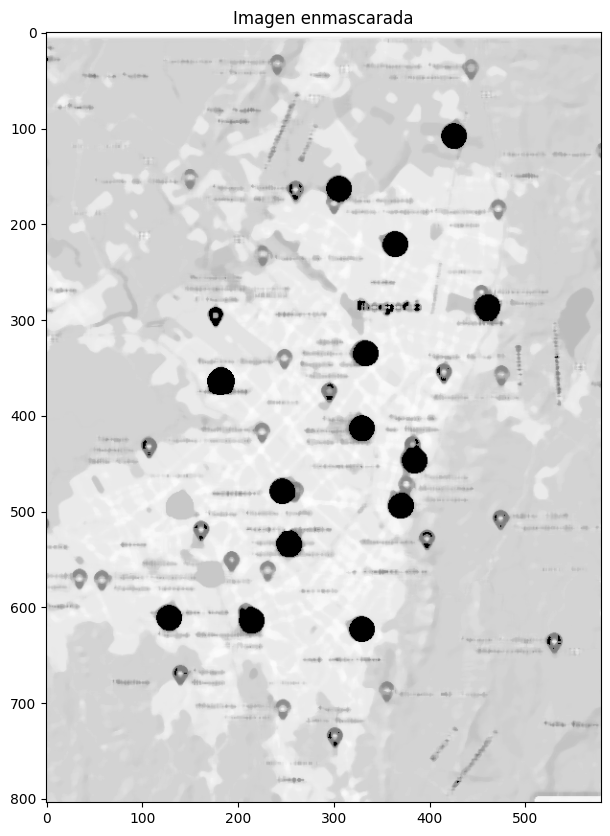

In [177]:

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar suavizado para mejorar la detección de círculos
image_blur = cv2.medianBlur(image_gray, 7)

# Definir el rango de valores de gris oscuro
lower_gray = 125
upper_gray = 255

# Crear una máscara para los píxeles oscuros
mask = cv2.inRange(image_blur, lower_gray, upper_gray)

# Aplicar la máscara a la imagen borrosa
masked_image = cv2.bitwise_and(image_blur, image_blur, mask=mask)

# Mostrar la imagen enmascarada
plt.figure(figsize=(10, 10))
plt.imshow(masked_image, cmap='gray')
plt.title('Imagen enmascarada')
plt.show()



# Identificación de coordenadas en la grilla

Se detectaron 16 círculos.


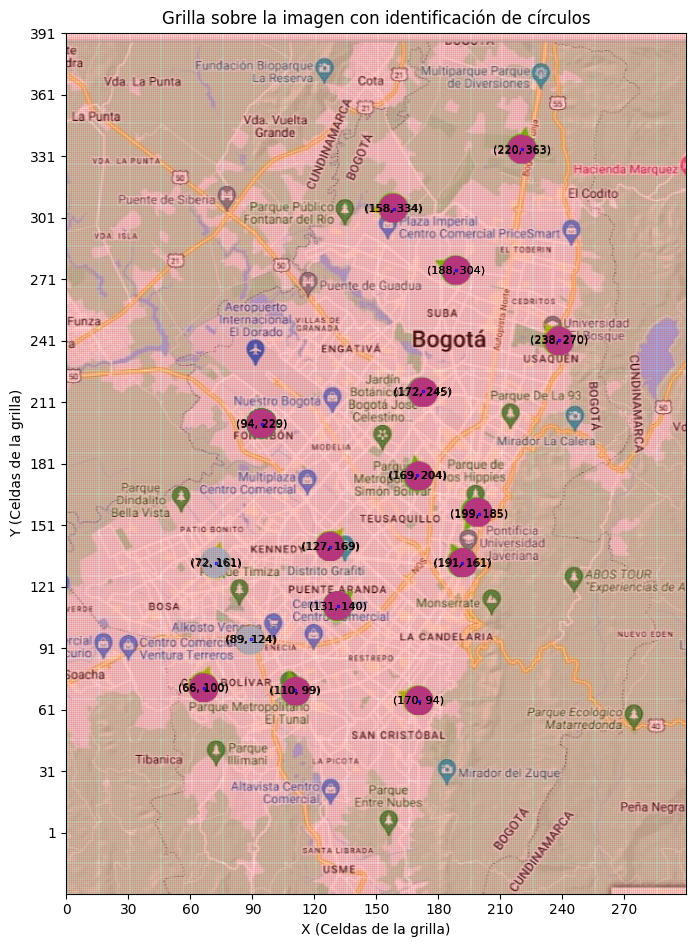

Número de estaciones contadas: 16


In [276]:
# Parámetros de la grilla
Lx = 300
Ly = int(Lx * 1.4)

# Detectar círculos usando la transformada de Hough
circles = cv2.HoughCircles(masked_image, cv2.HOUGH_GRADIENT, dp=1.5, minDist=20,
                           param1=50, param2=30, minRadius=13, maxRadius=21)

# Verificar si se han detectado círculos
if circles is not None:
    print(f'Se detectaron {circles.shape[1]} círculos.')
    
    # Redondear las coordenadas y el radio de los círculos
    circles = np.round(circles[0, :]).astype("int")
    
    # Crear una matriz para almacenar la grilla de posiciones de las estaciones
    height, width, _ = image.shape
    
    # Crear la matriz de posiciones de las estaciones
    stations_positions = np.zeros((Ly, Lx))

    # Crear una figura para visualizar la imagen y la grilla
    fig, ax = plt.subplots(figsize=(8, 12))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    cell_height = height / Ly  # Número de filas
    cell_width = width / Lx  # Número de columnas
    
    # Configurar los ticks en los ejes según la grilla
    interval_ticks = Lx // 10  # Intervalo adaptativo en función de Lx
    x_ticks = [i * cell_width for i in range(0, Lx, interval_ticks)]
    y_ticks = [j * cell_height for j in range(0, Ly, interval_ticks)]

    # Establecer los ticks y las etiquetas en función de la grilla
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels([str(i) for i in range(0, Lx, interval_ticks)])
    ax.set_yticklabels([str(j + 1) for j in reversed(range(0, Ly, interval_ticks))])

    # Procesar cada círculo detectado
    for (x, y, r) in circles:
        # Celda en la que se encuentra el círculo
        cell_x = int(x / cell_width)  # Convertir a entero
        cell_y = int((height - y) / cell_height)  # Invertir la coordenada y

        # Marcar la celda en la grilla, asegurándose de no exceder los límites
        if 0 <= cell_y < Ly and 0 <= cell_x < Lx:
            stations_positions[cell_y, cell_x] = 1
            # Anotar la posición del círculo con los índices corregidos
            # Invertimos la coordenada y para reflejar correctamente la posición en la grilla
            plt.text(x, y, f'({cell_x}, {cell_y})', color='black', fontsize=8, ha='center', va='center', alpha=1)

    # Colorear la grilla sobre la imagen
    for j in range(Lx):
        for i in range(Ly):
            # Dibujar un rectángulo azul en la celda si hay una estación
            if stations_positions[i, j] == 1:
                rect = patches.Rectangle((j * cell_width, (Ly -(i+1)) * cell_height), cell_width, cell_height, linewidth=1, edgecolor='b', facecolor='none', alpha=0.8)
                ax.add_patch(rect)
                # plt.text(j * cell_width + cell_width / 2, (Ly -(i+1)) * cell_height + cell_height / 2, f'({j}, {i})', color='black', fontsize=8, ha='center', va='center', alpha=1)
            else:
                # Dibujar un rectángulo rojo en la celda si no hay una estación
                rect = patches.Rectangle((j * cell_width, (Ly -(i+1)) * cell_height), cell_width, cell_height, linewidth=1, edgecolor='r', facecolor='none', alpha=0.1)
                ax.add_patch(rect)

    # Mostrar la imagen con las posiciones de los círculos y la grilla coloreada
    plt.title('Grilla sobre la imagen con identificación de círculos')
    plt.ylabel('Y (Celdas de la grilla)')
    plt.xlabel('X (Celdas de la grilla)')
    plt.show()
    print(f'Número de estaciones contadas: {len(stations_positions[stations_positions == 1])}')

else:
    print("No se detectaron círculos.")

# Relacionación con las estaciones reales

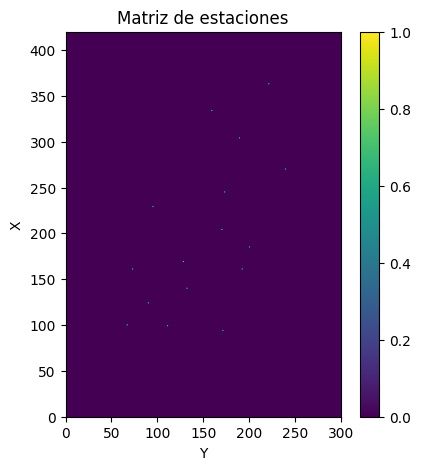

In [277]:
#Matiz de estaciones
plt.figure(figsize=(5,5))
# plt.imshow(stations_positions)
plt.imshow(stations_positions, extent=[0, Lx, 0, Ly], origin='lower')
plt.colorbar()
plt.ylabel('X')
plt.xlabel('Y')
plt.title('Matriz de estaciones')
plt.show()

In [278]:
#Lectura de estaciones
path_data = '../../Data/estaciones.txt'
data_estaciones = pd.read_csv(path_data)
data_estaciones

,Estación,VelViento,DirViento,PM10,Pm2.5
0,Guaymaral,True,True,True,True
1,Suba,True,True,True,True
2,Colina,True,True,True,True
3,Bolivia,False,False,False,True
4,Usaquén,True,True,True,True
5,Las Ferias,True,True,True,True
6,Fontibón,True,True,True,True
7,Estación Movil Fontibón,False,False,True,True
8,Centro de Alto Rendimiento,True,True,True,True
9,Móvil Séptima,True,True,True,True


In [279]:

# Filtrar el dataset por la columna "VelViento" igual a True
data_VelViento = data_estaciones[data_estaciones['VelViento'] == True]
data_VelViento

,Estación,VelViento,DirViento,PM10,Pm2.5
0,Guaymaral,True,True,True,True
1,Suba,True,True,True,True
2,Colina,True,True,True,True
4,Usaquén,True,True,True,True
5,Las Ferias,True,True,True,True
6,Fontibón,True,True,True,True
8,Centro de Alto Rendimiento,True,True,True,True
9,Móvil Séptima,True,True,True,True
10,Kennedy,True,True,True,True
11,Puente Aranda,True,True,True,True


In [280]:
coords_X, coords_Y = [], []
# Estas se recorren en i de izquierda a derecha y en j de arriba hacia abajo ya
# que en el dataset se encuentran las estaciones en orden de arriba hacia abajo 
# y de izquierda a derecha
coords_X, coords_Y = np.where(stations_positions == 1)
coords_X, coords_Y


(array([ 94,  99, 100, 124, 140, 161, 161, 169, 185, 204, 229, 245, 270,
        304, 334, 363], dtype=int64),
 array([170, 110,  66,  89, 131,  72, 191, 127, 199, 169,  94, 172, 238,
        188, 158, 220], dtype=int64))

In [281]:
# Asignar las coordenadas al DataFrame
data_VelViento['x_cell'] = coords_Y
data_VelViento['y_cell'] = coords_X


# Create a new DataFrame with station names and coordinates
data_estaciones_coords = data_VelViento[['Estación', 'x_cell', 'y_cell']].copy()
data_estaciones_coords.reset_index(drop=True, inplace=True)

# Print the new DataFrame
data_estaciones_coords

C:\Users\cterr\AppData\Local\Temp\ipykernel_8220\1789752546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_VelViento['x_cell'] = coords_Y
C:\Users\cterr\AppData\Local\Temp\ipykernel_8220\1789752546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_VelViento['y_cell'] = coords_X


,Estación,x_cell,y_cell
0,Guaymaral,170,94
1,Suba,110,99
2,Colina,66,100
3,Usaquén,89,124
4,Las Ferias,131,140
5,Fontibón,72,161
6,Centro de Alto Rendimiento,191,161
7,Móvil Séptima,127,169
8,Kennedy,199,185
9,Puente Aranda,169,204


In [282]:
data_VelViento.to_csv('../../Data/estaciones_coord.txt', sep=',', index=False)

In [283]:
def meters_per_pixel(pixel, distance):
    return distance/pixel

def time_per_pixel(distance):
    vel_sound = 343
    c = 1/np.sqrt(3)
    return (distance*c)/vel_sound

In [284]:
cell_height, cell_width

(1.9142857142857144, 1.93)

In [99]:
scale = meters_per_pixel(52,2000)
distance_cell = cell_width*scale
print(f'Distancia de las celdas: {distance_cell} m')

Distancia de las celdas: 31.813186813186814 m


In [100]:
time = time_per_pixel(distance_cell)
print(f'El click por celda es de {time} segundos')

El click por celda es de 0.05354913110895995 segundos


In [101]:
print(f'Cantidad de clikcs por hora: {3600/time} clicks/hora')

Cantidad de clikcs por hora: 67227.98158339567 clicks/hora


In [102]:
vel_sound = 343 
c = 1/np.sqrt(3)
vel_cel = (distance_cell*c)/time
vel_sound, vel_cel

(343, 343.0)